In [10]:
import PIL
import torchvision.transforms as transforms
import cv2
import math
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt
import seaborn as sns
import pickle
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns; sns.set()
import itertools
from torchvision.models import resnet152
import torch
from sklearn.metrics.pairwise import cosine_similarity
datas = ['mini_test', 'crop','euro','isic', 'chest']
plt.rcParams["figure.figsize"] = (8,12)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15

In [75]:
# simply to visaulize img
for idx in range(5):
    plt.imshow(x_support[idx].cpu().permute(1, 2, 0))
    plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

## clustering measure between support samples

In [41]:
# 1 shot -> 당연히 0이 나옴...
C = 5
N = 1
df = pd.DataFrame(None, columns = datas, index = [i for i in range(10)])
for data in datas:
    path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_001shot_head_default/feature/{}_support.npy'
    for i in range(10):
        denom = [] # 분모
        numer = [] # 분자
        support = np.load(path.format(data, i))
        mu = support.mean(axis=0).mean(axis=0)
        mu_i_arr = support.mean(axis=1)
        for cls in range(C):  
            index = [C*i + cls for i in range(N)]
            in_class = support[index]
            mu_i = np.mean(in_class, axis = 0)
            denom.append(np.linalg.norm(mu-mu_i) ** 2)
            for sample_idx in range(N):
                sample = in_class[sample_idx]
                numer.append(np.linalg.norm(sample-mu_i) ** 2)
        cluster_measure = C * sum(numer) / (N * sum(denom))
        df.loc[i, data] = cluster_measure
df

,mini_test,crop,euro,isic,chest
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0


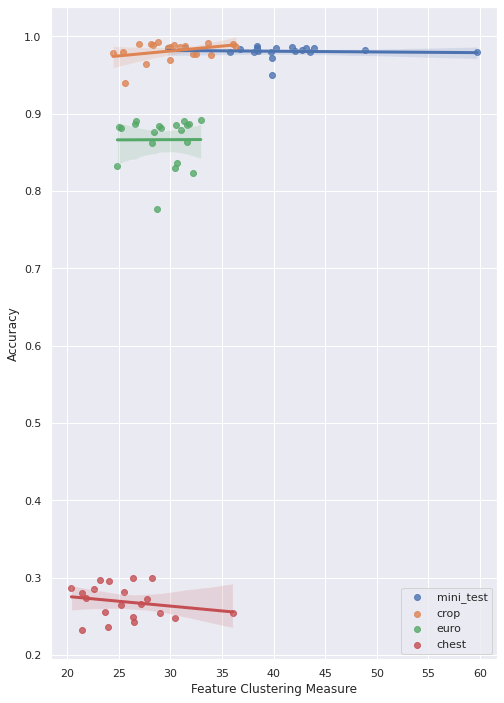

In [81]:
# 5 shot
C = 5
N = 5
df = pd.DataFrame(None, columns = datas, index = [i for i in range(20)])
for data in datas:
    path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_005shot_head_default/feature/{:03d}_support.npy'
    for i in range(20):
        denom = [] # 분모
        numer = [] # 분자
        support = np.load(path.format(data, i))
        mu = support.mean(axis=0)
        mu_i_arr = support.mean(axis=1)
        for cls in range(C):
            index = [C*i + cls for i in range(N)]
            in_class = support[index]
            mu_i = np.mean(in_class, axis = 0)
            denom.append(np.linalg.norm(mu-mu_i) ** 2)
            for sample_idx in range(N):
                sample = in_class[sample_idx]
                numer.append(np.linalg.norm(sample-mu_i) ** 2)
        cluster_measure = C * sum(numer) / (N * sum(denom))
        df.loc[i, data] = cluster_measure
df.index = ["support_{}".format(i) for i in range(20)]
# 5 shot
# 각 support에 대해 query의 평균임
for data in datas:
    acc_path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_005shot_head_default/sq_test_acc_20.csv'
    test_acc = pd.read_csv(acc_path.format(data), index_col='Unnamed: 0')
    support_acc = test_acc.mean(axis=1)
    pair_df = pd.concat([df.loc[:,data].astype(float), support_acc], axis=1)
    pair_df.columns =["Feature Clustering Measure", "Accuracy"]
    sns.regplot(x='Feature Clustering Measure', y='Accuracy', data=pair_df, label = data)
plt.legend()
plt.savefig('./img_pdf/support_query/support_clustering_5shot_20.pdf', bbox_inches='tight', format='pdf')

#### use cosine distance instead of euclidean distance

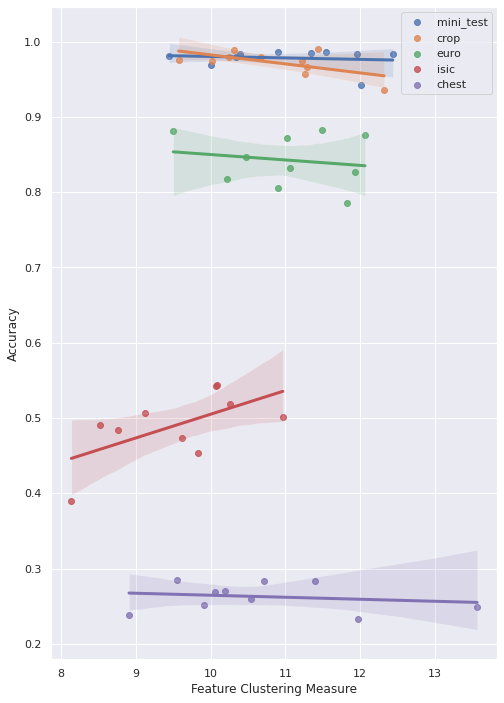

In [12]:
# 5 shot
C = 5
N = 5
df = pd.DataFrame(None, columns = datas, index = [i for i in range(10)])
for data in datas:
    path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_005shot_head_default/feature/{}_support.npy'
    for i in range(10):
        denom = [] # 분모
        numer = [] # 분자
        support = np.load(path.format(data, i))
        mu = support.mean(axis=0).reshape(1, -1)
        mu_i_arr = support.mean(axis=1)
        for cls in range(C):
            index = [C*i + cls for i in range(N)]
            in_class = support[index]
            mu_i = np.mean(in_class, axis = 0).reshape(1, -1)
            denom.append(cosine_distances(mu, mu_i))
            for sample_idx in range(N):
                sample = in_class[sample_idx].reshape(1, -1)
                numer.append(cosine_distances(sample, mu_i))
        cluster_measure = C * sum(numer) / (N * sum(denom))
        df.loc[i, data] = cluster_measure
df.index = ["support_{}".format(i) for i in range(10)]
# 5 shot
# 각 support에 대해 query의 평균임
for data in datas:
    acc_path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_005shot_head_default/sq_test_acc_10.csv'
    test_acc = pd.read_csv(acc_path.format(data), index_col='Unnamed: 0')
    support_acc = test_acc.mean(axis=1)
    pair_df = pd.concat([df.loc[:,data].astype(float), support_acc], axis=1)
    pair_df.columns =["Feature Clustering Measure", "Accuracy"]
    sns.regplot(x='Feature Clustering Measure', y='Accuracy', data=pair_df, label = data)
plt.legend()
plt.savefig('./img_pdf/support_query/support_clustering_5shot_cosine_20.pdf', bbox_inches='tight', format='pdf')

## clustering measure between query samples

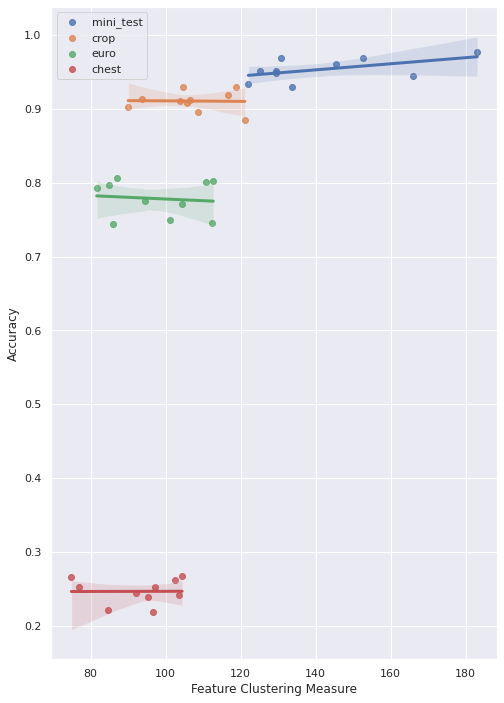

In [84]:
C = 5
N = 15
df = pd.DataFrame(None, columns = datas, index = [i for i in range(20)])
for data in datas:
    path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_001shot_head_default/feature/{:03d}_query.npy'
    for i in range(10):
        denom = [] # 분모
        numer = [] # 분자
        query = np.load(path.format(data, i))
        mu = query.mean(axis=0)
        mu_i_arr = query.mean(axis=1)
        for cls in range(C):
            index = [C*i + cls for i in range(N)]
            in_class = query[index]
            mu_i = np.mean(in_class, axis = 0)
            denom.append(np.linalg.norm(mu-mu_i) ** 2)
            for sample_idx in range(N):
                sample = in_class[sample_idx]
                numer.append(np.linalg.norm(sample-mu_i) ** 2)
        cluster_measure = C * sum(numer) / (N * sum(denom))
        df.loc[i, data] = cluster_measure
df.index = ["query_{}".format(i) for i in range(20)]
# 각 query 대해 support의 평균임
for data in datas:
    acc_path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_001shot_head_default/sq_test_acc_20.csv'
    test_acc = pd.read_csv(acc_path.format(data), index_col='Unnamed: 0')
    query_acc = test_acc.mean(axis=0)
    pair_df = pd.concat([df.loc[:,data].astype(float), query_acc], axis=1)
    pair_df.columns = ["Feature Clustering Measure", "Accuracy"]
    sns.regplot(x='Feature Clustering Measure', y='Accuracy', data=pair_df, label = data)
plt.legend()
plt.savefig('./img_pdf/support_query/query_clustering_1shot_20.pdf', bbox_inches='tight', format='pdf')

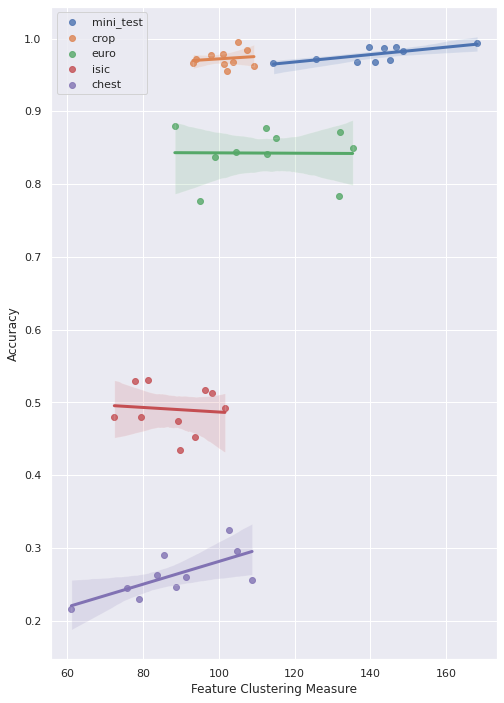

In [100]:
C = 5
N = 15
df = pd.DataFrame(None, columns = datas, index = [i for i in range(10)])
for data in datas:
    path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_005shot_head_default/feature/{}_query.npy'
    for i in range(10):
        denom = [] # 분모
        numer = [] # 분자
        query = np.load(path.format(data, i))
        mu = query.mean(axis=0)
        mu_i_arr = query.mean(axis=1)
        for cls in range(C):
            index = [C*i + cls for i in range(N)]
            in_class = query[index]
            mu_i = np.mean(in_class, axis = 0)
            denom.append(np.linalg.norm(mu-mu_i) ** 2)
            for sample_idx in range(N):
                sample = in_class[sample_idx]
                numer.append(np.linalg.norm(sample-mu_i) ** 2)
        cluster_measure = C * sum(numer) / (N * sum(denom))
        df.loc[i, data] = cluster_measure
df.index = ["query_{}".format(i) for i in range(10)]

# 각 query 대해 support의 평균임
for data in datas:
    acc_path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_005shot_head_default/sq_test_acc_10.csv'
    test_acc = pd.read_csv(acc_path.format(data), index_col='Unnamed: 0')
    query_acc = test_acc.mean(axis=0)
    pair_df = pd.concat([df.loc[:,data].astype(float), query_acc], axis=1)
    pair_df.columns = ["Feature Clustering Measure", "Accuracy"]
    sns.regplot(x='Feature Clustering Measure', y='Accuracy', data=pair_df, label = data)
plt.legend(loc = 'best')
plt.savefig('./img_pdf/support_query/query_clustering_5shot_10.pdf', bbox_inches='tight', format='pdf')

### Cosine Similarity between Support Samples (Features)

<AxesSubplot:>

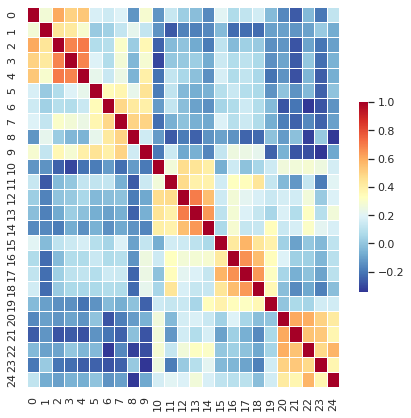

In [271]:
path = './logs/baseline/output/torch_resnet18_simclr_LS_default/mini_test/05way_005shot_head_default/feature/0_support.npy'
support = np.load(path)
fig, ax = plt.subplots( figsize=(7,7) )
# naive similarity btw all 25 samples
#support_all = support.swapaxes(0,1).reshape(25, 512)
sim = cosine_similarity(support, support)
sns.heatmap(sim, 
            cmap = 'RdYlBu_r', 
            #annot = True,   # 실제 값을 표시한다
            #mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = sim.min(), vmax = sim.max()   # 컬러바 범위 -1 ~ 1
           )  
# in-class similarity

사실 넘 당연한 결과라 딱히 설명할것도 없음 -> visualization?

## Hardness between Support and Query

In [3]:
def get_classifier(yh, y): # support_features, y_support

    classifier = torch.zeros((y.unique().size(0), yh.size(1))) # (5, 1000)
    for cls in torch.sort(y.unique())[0]:
        classifier[cls] = yh[y == cls].mean(dim=0) # z(x,theta)
    classifier = torch.nn.functional.normalize(classifier) # ReLU + l2 normalize
    return classifier

def get_hardness(x_support, y_support, x_query, y_query):
    with torch.no_grad():
        yhs_list = []
        # for feature in x_support: # 크기 최대 75씩 자름, zip : (x,y)가 최대 75개 
        #     yhs_list.append(torch.from_numpy(feature))

        support_features = torch.from_numpy(x_support)

        w = get_classifier(support_features, y_support) # w 계산 

        yhq_list = []
        # for feature in x_query: # 크기 최대 75씩 자름, zip : (x,y)가 최대 75개 
        #     yhq_list.append(torch.from_numpy(feature))
        query_features = torch.from_numpy(x_query) 
        phi = torch.nn.functional.normalize(query_features) # phi : l2 norm normalized
        # class개수 * class 개수 (5 x 5) 

        z = phi @ w.t() # z_y = w * phi(x)   (75, 5)

        p = torch.softmax(z, dim=1) # p(.|x) (75, 5)
        p = p[torch.arange(0, y_query.size(0)), y_query] #p(y|x)
        
        hardness = ((1. - p) / p).log().mean().item()
    return hardness 

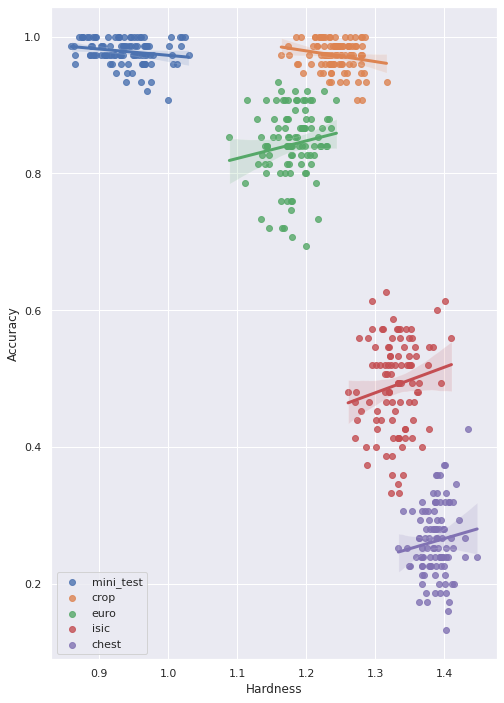

In [102]:
# 1shot

for data in datas:
    df = pd.DataFrame(None, columns = range(10), index = range(10))
    path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_001shot_head_default/feature/{}_{}.npy'
    acc_path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_005shot_head_default/sq_test_acc_10.csv'.format(data)
    test_acc = pd.read_csv(acc_path.format(data), index_col='Unnamed: 0')
    for support_episode in range(10):
        for query_episode in range(10):
            x_support = np.load(path.format(data, support_episode,'support'))
            x_query = np.load(path.format(data, query_episode, 'query'))
            y_support = torch.arange(5).repeat_interleave(1)
            y_query = torch.arange(5).repeat_interleave(15)

            hardness = get_hardness(x_support, y_support, x_query, y_query)
            df.loc[support_episode, query_episode] = hardness
    sns.regplot(x=df.values.reshape(-1).astype(float), y=test_acc.values.reshape(-1), label = data)
    plt.legend(loc="lower left")
plt.xlabel('Hardness')
plt.ylabel('Accuracy')
plt.savefig('./img_pdf/support_query/support_query_hardness_1shot.pdf', bbox_inches='tight', format='pdf')

In [17]:
"$s{}$".format(next(iter([i for i in range(0, 10)])))

'$s0$'

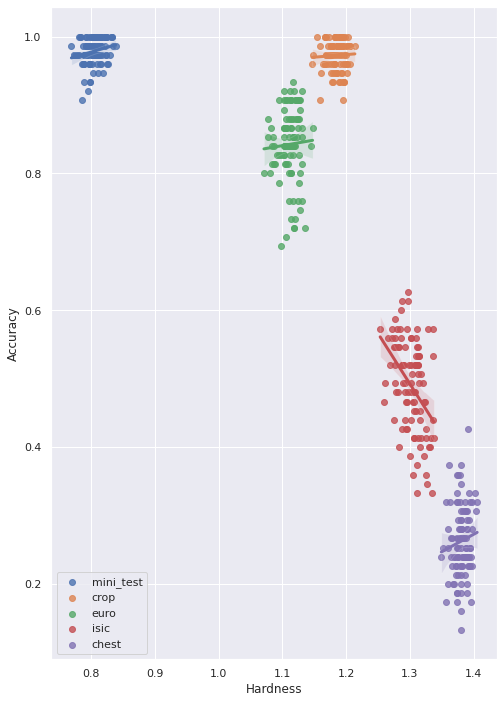

In [99]:
# 5shot

for data in datas:
    df = pd.DataFrame(None, columns = range(10), index = range(10))
    path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_005shot_head_default/feature/{}_{}.npy'
    acc_path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_005shot_head_default/sq_test_acc_10.csv'.format(data)
    test_acc = pd.read_csv(acc_path.format(data), index_col='Unnamed: 0')
    for support_episode in range(10):
        for query_episode in range(10):
            x_support = np.load(path.format(data, support_episode,'support'))
            x_query = np.load(path.format(data, query_episode, 'query'))
            y_support = torch.arange(5).repeat_interleave(5)
            y_query = torch.arange(5).repeat_interleave(15)

            hardness = get_hardness(x_support, y_support, x_query, y_query)
            df.loc[support_episode, query_episode] = hardness
    sns.regplot(x=df.values.reshape(-1).astype(float), y=test_acc.values.reshape(-1), label = data)
    plt.legend(loc='lower left')
plt.xlabel('Hardness')
plt.ylabel('Accuracy')
plt.savefig('./img_pdf/support_query/support_query_hardness_5shot_10.pdf', bbox_inches='tight', format='pdf')

In [88]:
len(df.values.reshape(-1).astype(float))

400

### Best Epoch vs Accuracy

In [15]:
test_acc

,query_0,query_1,query_2,query_3,query_4,query_5,query_6,query_7,query_8,query_9
support_0,0.213333,0.320000,0.266667,0.240000,0.253333,0.173333,0.173333,0.240000,0.253333,0.200000
support_1,0.186667,0.293333,0.253333,0.226667,0.306667,0.240000,0.240000,0.280000,0.266667,0.200000
support_2,0.200000,0.240000,0.280000,0.226667,0.333333,0.293333,0.306667,0.186667,0.266667,0.266667
support_3,0.133333,0.160000,0.320000,0.213333,0.240000,0.253333,0.253333,0.226667,0.280000,0.306667
support_4,0.226667,0.226667,0.253333,0.226667,0.306667,0.240000,0.200000,0.266667,0.253333,0.320000
support_5,0.240000,0.213333,0.333333,0.186667,0.320000,0.240000,0.320000,0.373333,0.226667,0.240000
support_6,0.280000,0.213333,0.346667,0.226667,0.333333,0.266667,0.253333,0.373333,0.240000,0.320000
support_7,0.266667,0.293333,0.320000,0.240000,0.360000,0.240000,0.293333,0.360000,0.226667,0.240000
support_8,0.266667,0.280000,0.266667,0.200000,0.426667,0.240000,0.186667,0.306667,0.280000,0.253333
support_9,0.280000,0.320000,0.320000,0.173333,0.360000,0.280000,0.226667,0.293333,0.306667,0.280000


In [125]:
acc_path = './logs/baseline/output/torch_resnet18_simclr_LS_default/mini_test/05way_005shot_head_default/test_history.csv'.format(data)
test_acc = pd.read_csv(acc_path.format(data), index_col='Unnamed: 0')
sorted(round((test_acc.iloc[:,-1]*75)).unique())

[65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0]

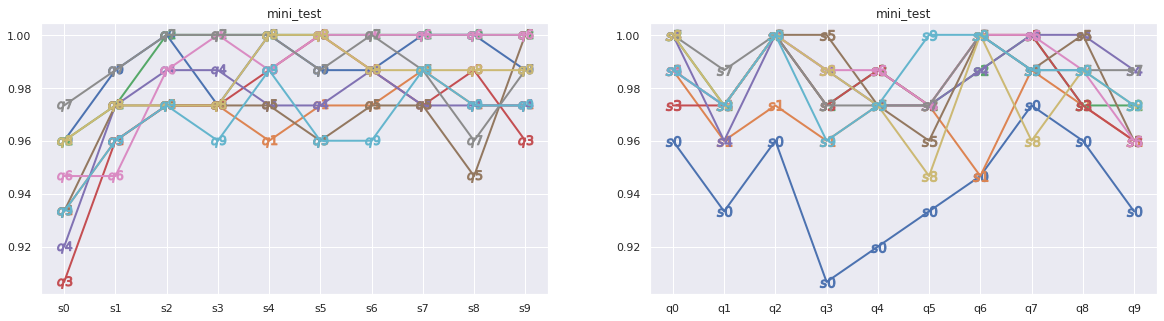

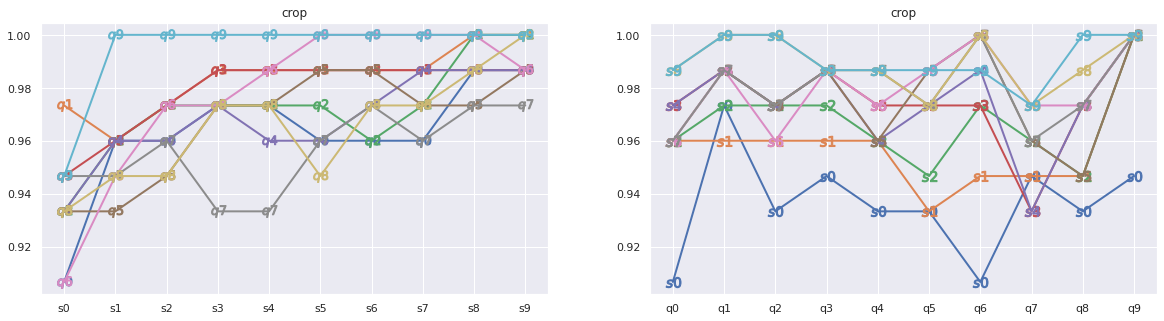

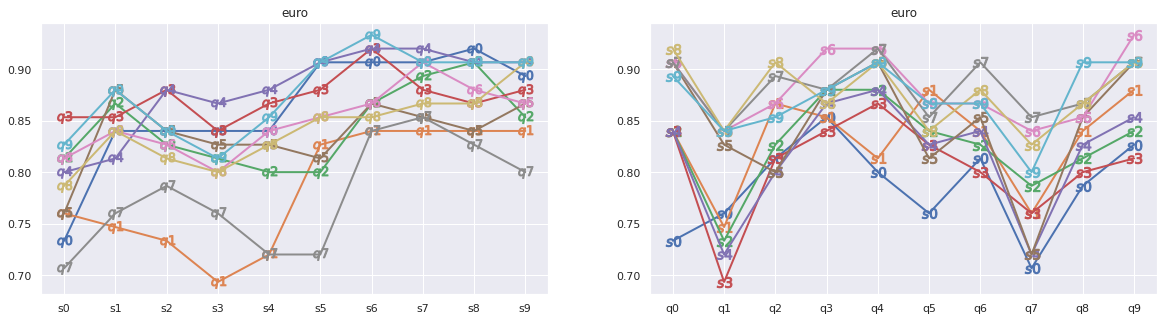

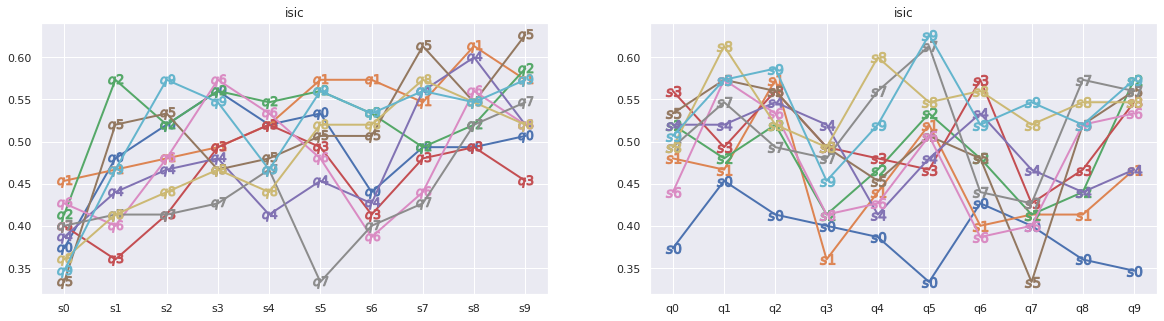

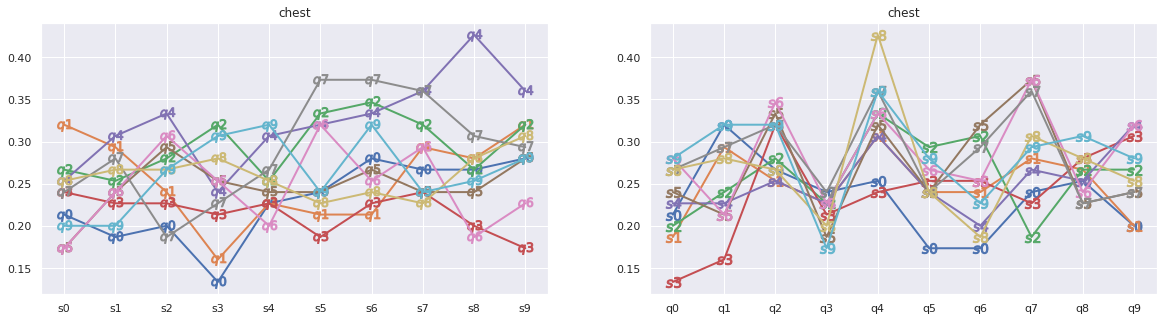

In [101]:
for data in datas:
    acc_path = './logs/baseline/output/torch_resnet18_simclr_LS_default/{}/05way_005shot_head_default/sq_test_acc_10.csv'.format(data)
    test_acc = pd.read_csv(acc_path.format(data), index_col='Unnamed: 0')
    test_acc.columns = ["q{}".format(i) for i in range(10)]
    test_acc.index = ["s{}".format(i) for i in range(10)]
    plt.figure(figsize=(20, 5))
    plt.subplot(212)
    # equivalent but more general
    ax1 = plt.subplot(1, 2, 1)
    plt.title(data)
    # add a subplot with no frame
    ax2 = plt.subplot(1, 2, 2)
    for idx in range(10):
        ax1.plot(test_acc.iloc[:,idx], marker='$q{}$'.format(idx),markersize=15)
    for idx in range(10):
        ax2.plot(test_acc.T.iloc[:,idx], marker='$s{}$'.format(idx), markersize=15)
    plt.title(data)
    plt.savefig('./img_pdf/support_query/5shot_dist_{}.pdf'.format(data), bbox_inches='tight', format='pdf')
    plt.show()
